In [91]:
import sys; sys.path.append('..'); from wwa import *
mapproj = cartopy.crs.PlateCarree()

xn, xx, yn, yx = [50,60.25,20,26.5] # revised after comparison with station data

# Prepare data for gridded trend fitting

In [28]:
era5 = xr.concat([xr.open_dataset("../../00_WWA_project_folder/ephemeral/Oman_UAE_floods/era5/era5_pr_climexp.nc").pr,
                  xr.open_dataset("../../00_WWA_project_folder/ephemeral/Oman_UAE_floods/era5/era5_pr_cds.nc").tp.rename("pr", latitude = "lat", longitude = "lon").sel(time = "2024-04")], "time")
era5_rx1day = era5.resample(time = "AS-JUL").max()

rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(era5_rx1day.lon, era5_rx1day.lat)
era5_rx1day = era5_rx1day.where(rm == 0).assign_coords(time = era5_rx1day.time.dt.year).rename(time = "year")

In [29]:

# save the map for easier reconstruction
era5_rx1day.mean("year").to_netcdf("era5_tmplt.nc")

# flatten & save as .csv for transfer to R
era5_rx1day.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas().to_csv("era5_flattened.csv")

# Trend maps

## Reshape data

In [30]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [31]:
for ds in ["era5"]:
    
    # load map to be used to reshape
    tmplt = xr.open_dataset(ds+"_tmplt.nc").pr
    
    df = pd.read_csv("gridded-res_"+ds+".csv", index_col = 0)
    mdl_res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])
    mdl_res.to_netcdf(ds+"-gridded.nc")

## Plot trends

In [113]:
plot_kwargs = {"mu0"        : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000},
               "disp"       : {"cmap" : "viridis", "vmin" : 0},
               "alpha_gmst" : {"cmap" : "BrBG", "vmin" : -500, "vmax" : 500},
               "alpha_nino" : {"cmap" : "BrBG", "vmin" : -500, "vmax" : 500},
               "event_magnitude" : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000},
               "return_period"   : {"cmap" : "viridis", "vmin" : 0, "vmax" : 50},
               "rp_neut"         : {"cmap" : "viridis", "vmin" : 0, "vmax" : 250},
               "PR_hist"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20},
               "PR_neut"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20},
               "dI_rel_hist" : {"cmap" : "BrBG", "vmin" : -150, "vmax" : 150},
               "dI_rel_neut" : {"cmap" : "BrBG", "vmin" : -30, "vmax" : 30},
               "dI_abs_hist" : {"cmap" : "BrBG", "vmin" : -50, "vmax" : 50},
               "dI_abs_neut" : {"cmap" : "BrBG", "vmin" : -10, "vmax" : 10},}

main = {"return_period" : "Return period of 2024 event",
        "dI_rel_hist" : "(a) % change in rx1day due to 1.2C change in GMST",
        "dI_rel_neut" : "(b) % change in rx1day due to current El Nino state",
        "dI_abs_hist" : "(a) change in rx1day due to 1.2C change in GMST (mm)",
        "dI_abs_neut" : "(a) change in rx1day due to current El Nino state (mm)",}

label = {"return_period" : "Return period (years)",
         "dI_rel_hist" : "% change in rx1day",
         "dI_rel_neut" : "% change in rx1day",
         "dI_abs_hist" : "Change in rx1day (mm)",
         "dI_abs_neut" : "Change in rx1day (mm)",}


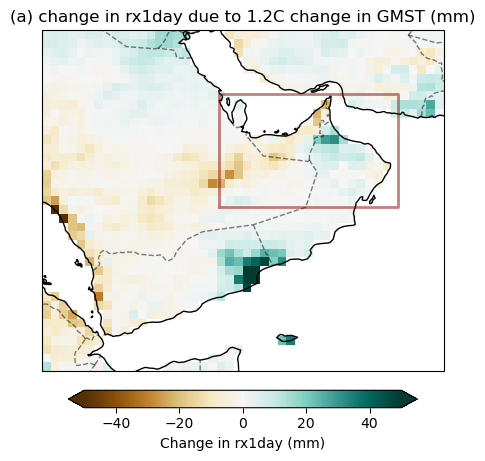

In [115]:
varnm = "dI_abs_hist"
da = xr.open_dataset("era5-gridded.nc")

fig, ax = plt.subplots(ncols = 1, figsize = (6,5), dpi = 100, subplot_kw={"projection" : mapproj})
cbar_kwargs = {"location" : "bottom", "fraction" : 0.065, "shrink" : 0.75, "pad" : 0.05} | {"label" : label[varnm]}

da[varnm].plot(ax = ax, add_colorbar = True, cbar_kwargs = cbar_kwargs, **plot_kwargs[varnm])
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)
ax.set_title(main[varnm])

plt.savefig("fitted-models_era5-gridded_"+varnm+".png")